# A brief introduction to Hierarchical Bayesian Models (HBMs)

**Author**: Luis G. Leon Vega
Instituto Tecnológico de Costa Rica - Master in Electronics Engineering

**Attribution**: This work is an adaptation of the original work for PyStan demo by Chris Fonnesbeck. Most of the code is originally under the license Apache, Version 2.0 (code); CC-BY 3.0 (text).

Hierarchical or multilevel modelling is a generalisation of regression modelling. HBMs are one of the examples of the multilevel modelling, hierarchicalising the Bayes Inference into different levels which now allow to accept data incoming from different sources, which can have different uncertainties linked to the measurements.
One of the key points of HBMs is the possibility to take the data errors into their favour to strengthen the model generalisation. This characteristic makes HBMs different to all Machine Learning methods, since they assume that the data come from the same source.
Another important aspect is that HBMs rely on Bayesian Inference, making this method enter into the statistical methods.
Another application is the acceptance of hierarchical data, such as epidemics datasets, taxonomies, etc. For more details, please refer to [this paper](../paper/main.pdf).

### Example: Radon contamination (Gelman and Hill 2006)

Radon is a radioactive gas that enters homes through contact points with the ground. It is a carcinogen that is the primary cause of lung cancer in non-smokers. Radon levels vary greatly from household to household.

![radon](https://www.suro.cz/en/prirodnioz/rnprogram/pronikaniNAHLED.gif)

The EPA did a study of radon levels in 80,000 houses. Two important predictors:

* measurement in the basement or first floor (radon higher in basements)
* county uranium level (positive correlation with radon levels)

We will focus on modelling radon levels in Arizona.

The hierarchy in this example is households within the county.

### Data organization

First, we import the data from a local file, and extract Arizona's data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')

# Import radon data
srrs2 = pd.read_csv('data/srrs2.dat')
srrs2.columns = srrs2.columns.map(str.strip)

# FIPS: it is referred to the location where the measurement took place
srrs_az = srrs2.assign(fips=srrs2.stfips*1000 + srrs2.cntyfips)[srrs2.state=='AZ']

Next, obtain the county-level predictor, uranium, by combining two variables.

In [2]:
cty = pd.read_csv('data/cty.dat')
cty_az = cty[cty.st=='AZ'].copy()
cty_az[ 'fips'] = 1000 * cty_az.stfips + cty_az.ctfips

Use the `merge` method to combine home- and county-level information in a single DataFrame. We are interested where the measurements took place and the uranium level on that specific place.

In [3]:
srrs_az = srrs_az.merge(cty_az[['fips', 'Uppm']], on='fips')
srrs_az = srrs_az.drop_duplicates(subset='idnum')
srrs_az = srrs_az[srrs_az.Uppm != 0.]
u = np.log(srrs_az.Uppm)
n = len(srrs_az)

In [4]:
srrs_az.columns

Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm'],
      dtype='object')

In [5]:
srrs_az.head()

idnum state state2  stfips    zip  region  typebldg  floor  room basement  \
0      1    AZ     AZ       4  85920       1         1      1     2        N   
1      2    AZ     AZ       4  85920       1         0      9     0            
2      3    AZ     AZ       4  85924       1         1      1     3        N   
3      4    AZ     AZ       4  85925       1         1      1     3        N   
4      5    AZ     AZ       4  85932       1         1      1     1        N   

   ...  stopdt activity  pcterr       adjwt  dupflag  zipflag  cntyfips  \
0  ...  120287      0.3     0.0  136.060971        0        0         1   
1  ...   71188      0.6    33.3  128.784975        0        0         1   
2  ...   70788      0.5     0.0  150.245112        0        0         1   
3  ...   52288      0.6    97.2  136.060971        0        0         1   
4  ...   70788      0.3     0.0  136.060971        0        0         1   

                 county  fips     Uppm  
0  APACHE                4001  2.26437  
1  APACHE                4001  2.26437  
2  APACHE                4001  2.26437  
3  APACHE                4001  2.26437  
4  APACHE                4001  2.26437  

[5 rows x 27 columns]

We also need a lookup table (`dict`) for each unique county, for indexing.

In [6]:
srrs_az.county = srrs_az.county.str.strip()
az_counties = srrs_az.county.unique()
counties = len(az_counties)

In [7]:
print(counties, az_counties)

14 ['APACHE' 'COCHISE' 'COCONINO' 'GILA' 'GRAHAM' 'GREENLEE' 'MARICOPA'
 'MOHAVE' 'NAVAJO' 'PIMA' 'PINAL' 'SANTA CRUZ' 'YAVAPAI' 'YUMA']


Finally, create local copies of variables. In this case, we would like also the radon in its logarithm form.

In [8]:
county_lookup = dict(zip(az_counties, range(len(az_counties))))
county = srrs_az['county_code'] = srrs_az.county.replace(county_lookup).values
radon = srrs_az.activity
srrs_az['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_az.floor.values
u = np.log(srrs_az.Uppm)

In [9]:
plt.figure()
plt.scatter(srrs_az['Uppm'], radon)
plt.scatter(srrs_az['Uppm'], log_radon)

Distribution of radon levels in AZ (log scale):

In [10]:
srrs_az['log_radon'].hist(bins=25)

## Non-hierarchical approaches

According to the paper, there are three Bayesian inference frameworks to approach this problem:

***Complete pooling***: 

Treat all counties the same, and estimate a single radon level.

$$y_i = \alpha + \beta x_i + \epsilon_i$$

***No pooling***:

Model radon in each county independently.

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

where $j = 1,\ldots,15$

The errors $\epsilon_i$ may represent measurement error, temporal within-house variation, or variation among houses.

### Pooling

To specify this model in Stan, we begin by constructing the `data` block, which includes vectors of log-radon measurements (`y`) and floor measurement covariates (`x`), as well as the number of samples (`N`).

In [11]:
pooled_data = """
data {
  int<lower=0> N; 
  vector[N] x;
  vector[N] y;
}
"""

Next we initialise our parameters, which in this case are the linear model coefficients and the normal scale parameter. Notice that `sigma` is constrained to be positive.

In [12]:
pooled_parameters = """
parameters {
  vector[2] beta;
  real<lower=0> sigma;
} 
"""

Finally, we model the log-radon measurements as a normal sample with a mean that is a function of the floor measurement.

In [13]:
pooled_model = """
model {
  y ~ normal(beta[1] + beta[2] * x, sigma);
}
"""

We then pass the code, data, and parameters to the `stan` function. The sampling requires specifying how many iterations we want, and how many parallel chains to sample. Here, we will sample 2 chains of length 1000.

In [14]:
import pystan

pooled_data_dict = {'N': len(log_radon),
               'x': floor_measure,
               'y': log_radon}

pooled_fit = pystan.stan(model_code=pooled_data + pooled_parameters + pooled_model, 
                         data=pooled_data_dict, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dd6a876b770652d53bdcc0546345af4b NOW.


The sample can be extracted for plotting and summarisation.

In [15]:
pooled_sample = pooled_fit.extract(permuted=True)

In [16]:
b0, m0 = pooled_sample['beta'].T.mean(1)

In [17]:
plt.scatter(srrs_az.floor, np.log(srrs_az.activity+0.1))
xvals = np.linspace(-0.2, 10)
plt.plot(xvals, m0*xvals+b0, 'r--')
_ = plt.xlabel("Floor")
_ = plt.ylabel("Log(radon)")

The dispersion of the data amongst the floors are significant. It is not possible to make a logical conclusion from the data. For example, being on the 9th floor has a similar effect to being at the basement (floor #0). Indeed, there is a missing variable to make a better conclusion from the plot. Also, there is not enough data to train the model on the 4-8 floors. This missing information will be the reason of training a generalised model.

### Unpooled

At the other end of the extreme, we can fit separate (independent) means for each county. The only things which are shared in this model are the coefficient for the basement measurement effect, and the standard deviation of the error.

Similarly to the pooling case, the new model should be defined. The data now contains the index of the county, which is constrained to hold 15 counties.

In the model, the $y$ will be distributed within a normal distribution, which will have as a mean value the bias, which now is different for each county.

In [22]:
unpooled_model = """data {
  int<lower=0> N; 
  int<lower=1,upper=14> county[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[14] a;
  real beta;
  real<lower=0,upper=100> sigma;
} 
transformed parameters {
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- beta * x[i] + a[county[i]];
}
model {
  y ~ normal(y_hat, sigma);
}"""

In [23]:
unpooled_data = {'N': len(log_radon),
               'county': county+1, # Stan counts starting at 1
               'x': floor_measure,
               'y': log_radon}

unpooled_fit = pystan.stan(model_code=unpooled_model, data=unpooled_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_669f2b92f4bb9e903ddbe7c2b31fddbd NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [24]:
unpooled_estimates = pd.Series(unpooled_fit['a'].mean(0), index=az_counties)
unpooled_se = pd.Series(unpooled_fit['a'].std(0), index=az_counties)

We can plot the ordered estimates to identify counties with high radon levels:

In [26]:
order = unpooled_estimates.sort_values().index

plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.xlim(-1,16); plt.ylim(-1,1)
plt.ylabel('Radon estimate');plt.xlabel('Ordered county');

From the plot, it is possible to see that the counties influence on the mean average of the radon estimates. Moreover, the uncertainty levels are also different for each county, having the first one as an outlier.

Here are visual comparisons between the pooled and unpooled estimates for a subset of counties representing a range of sample sizes.

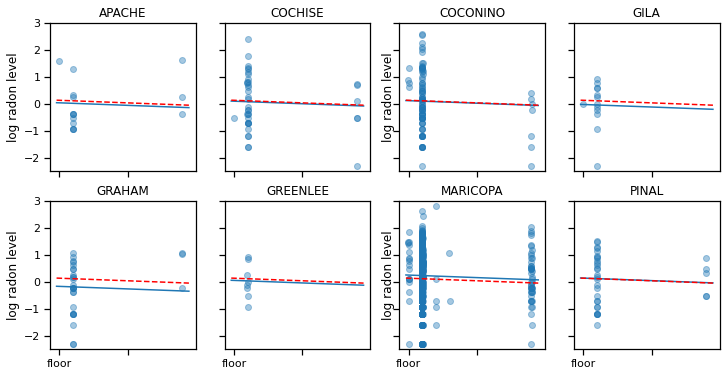

In [29]:
sample_counties = ('APACHE', 'COCHISE', 'COCONINO', 'GILA', 
                   'GRAHAM', 'GREENLEE', 'MARICOPA', 'PINAL')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_fit['beta'].mean(0)
for i,c in enumerate(sample_counties):
    y = srrs_az.log_radon[srrs_az.county==c]
    x = srrs_az.floor[srrs_az.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    b = unpooled_estimates[c]
    
    # Plot both models and data
    xvals = np.linspace(-0.2, 9.5)
    axes[i].plot(xvals, m*xvals+b)
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-2.5, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

Dashed red: pooled
Continous blue: unpooled

Neither of these models are satisfactory:

* if we are trying to identify high-radon counties, pooling is useless. Also, the uncertainty linked to it is high.
* we do not trust extreme unpooled estimates produced by models using few observations: the case of Greenlee and Gila are examples of this.

## Multilevel and hierarchical models

When we pool our data, we imply that they are sampled from the same model. It ignores any variation among sampling units (other than sampling variance):

![pooled](http://f.cl.ly/items/0R1W063h1h0W2M2C0S3M/Screen%20Shot%202013-10-10%20at%208.22.21%20AM.png)

When we analyse data unpooled, we imply that they are sampled independently from separate models. At the opposite extreme from the pooled case, this approach claims that differences between sampling units are too large to combine them:

![unpooled](http://f.cl.ly/items/38020n2t2Y2b1p3t0B0e/Screen%20Shot%202013-10-10%20at%208.23.36%20AM.png)

In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***partial pooling***.

![hierarchical](http://f.cl.ly/items/1B3U223i002y3V2W3r0W/Screen%20Shot%202013-10-10%20at%208.25.05%20AM.png)

We can use PyStan to easily specify multilevel models, and fit them using Hamiltonian Monte Carlo.

## Partial pooling model

The simplest partial pooling model for the household radon dataset is one which estimates radon levels, without any predictors at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled county estimates and the poll estimates.

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

* $\hat{\alpha}$ - partially-pooled estimate of radon level
* $n_j$ - number of samples in county $j$
* $\bar{y}_j$ - estimated mean for county $j$
* $\sigma_y^2$ - s.e. of $\bar{y}_j$, variability of the county mean
* $\bar{y}$ - pooled mean estimate for $\alpha$
* $\sigma_{\alpha}^2$ - s.e. of 

The effect of alpha:

- Estimates for counties with smaller sample sizes will shrink towards the state-wide average.
- Estimates for counties with larger sample sizes will be closer to the unpooled county estimates.

In [30]:
partial_pooling = """
data {
  int<lower=0> N; 
  int<lower=1,upper=14> county[N];
  vector[N] y;
} 
parameters {
  vector[14] a;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] <- a[county[i]];
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal (10 * mu_a, sigma_a);

  y ~ normal(y_hat, sigma_y);
}"""

Notice now we have two standard deviations, one describing the residual error of the observations, and another the variability of the county means around the average. This last one can be taken as a measurement error or a global location error. It encapsulates the several factors which can contribute to the error.

In [31]:
partial_pool_data = {'N': len(log_radon),
               'county': county + 1, # Stan counts starting at 1
               'y': log_radon}

partial_pool_fit = pystan.stan(model_code=partial_pooling, data=partial_pool_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1dc99f5e56afd847fd24993469980894 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Text(0, 0.5, 'Log(radon)')

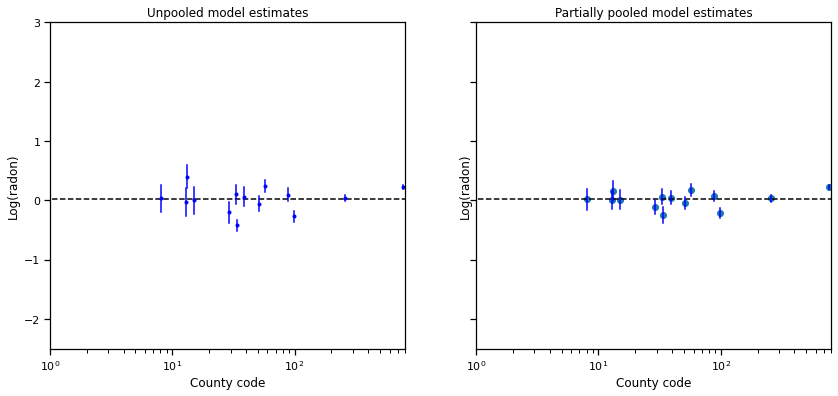

In [32]:
sample_trace = partial_pool_fit['a']

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
samples, counties = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=counties)

n_county = srrs_az.groupby('county')['idnum'].count()
unpooled_means = srrs_az.groupby('county')['log_radon'].mean()
unpooled_sd = srrs_az.groupby('county')['log_radon'].std()
unpooled = pd.DataFrame({'n':n_county, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 0.9, 800, linestyles='--')
axes[0].set_xlabel("County code")
axes[0].set_ylabel("Log(radon)")

        
samples, counties = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].scatter(n_county.values + jitter, means)
axes[1].set_xscale('log')
axes[1].set_xlim(1,800)
axes[1].set_ylim(-2.5, 3)
axes[1].hlines(sample_trace.mean(), 0.9, 800, linestyles='--')
for j,n,m,s in zip(jitter, n_county.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-')

axes[0].set_title("Unpooled model estimates")
axes[1].set_title("Partially pooled model estimates")
axes[1].set_xlabel("County code")
axes[1].set_ylabel("Log(radon)")

Notice the difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes. The former are both more extreme and more imprecise. The model learnt how to shrink the imprecisions of the high-variable counties according to the model established for $\hat{\alpha}$.

## Varying intercept model

This model allows intercepts to vary across the county, according to a random effect.

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

As with the the “no-pooling” model, we set a separate intercept for each county, but rather than fitting separate least squares regression models for each county, multilevel modelling **shares strength** among counties, allowing for more reasonable inference in counties with little data.

In [33]:
varying_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> county[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[J] a;
  real b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {

  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- a[county[i]] + x[i] * b;
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal (mu_a, sigma_a);

  b ~ normal (0, 1);

  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [34]:
varying_intercept_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': county+1, # Stan counts starting at 1
                          'x': floor_measure,
                          'y': log_radon}

varying_intercept_fit = pystan.stan(model_code=varying_intercept, data=varying_intercept_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2135d8c8ee1e308d258926ab856409dc NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [35]:
a_sample = pd.DataFrame(varying_intercept_fit['a'])

In [36]:
import seaborn as sns
sns.set(style="ticks", palette="muted", color_codes=True)

# Plot the orbital period with horizontal boxes
plt.figure(figsize=(16, 6))
sns.boxplot(data=a_sample, whis=np.inf, color="c")

In [37]:
varying_intercept_fit.plot(pars=['sigma_a', 'b']);

In [38]:
varying_intercept_fit['b'].mean()

-0.018445784860007086

The estimate for the `floor` coefficient is approximately -0.02 (when $x = 0$), which can be interpreted as houses without basements having about half ($\exp(-0.02) = 0.9801$) the radon levels of those with basements, after accounting for the county.

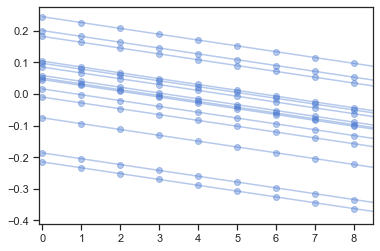

In [39]:
xvals = np.arange(10)
bp = varying_intercept_fit['a'].mean(axis=0)
mp = varying_intercept_fit['b'].mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,8.5);

It is easy to show that the partial pooling model provides more objectively reasonable estimates than either the pooled or unpooled models, at least for counties with small sample sizes. From the plot shown above, it is possible to see how the intercept changes from one county to another.

In [40]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i,c in enumerate(sample_counties):
    # Plot county data
    y = srrs_az.log_radon[srrs_az.county==c]
    x = srrs_az.floor[srrs_az.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    m = unpooled_fit['beta'].mean(0)
    b = unpooled_estimates[c]
    
    xvals = np.linspace(-0.2, 10)
    # Unpooled estimate
    axes[i].plot(xvals, m*xvals+b)
    # Pooled estimate
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    # Partial pooling esimate
    axes[i].plot(xvals, mp*xvals+bp[county_lookup[c]], 'k:')
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-2.5, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

From the plots shown above, it is possible to see that, still, with changing the intercept model the model seems to be affected by the slope: the case of Cochise, Apache and Graham.

## Varying slope model

Alternatively, we can posit a model that allows the counties to vary according to how the location of measurement (basement or floor) influences the radon reading.

$$y_i = \alpha + \beta_{j[i]} x_{i} + \epsilon_i$$


In [41]:
varying_slope = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> county[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  real a;
  vector[J] b;
  real mu_b;
  real<lower=0,upper=100> sigma_b;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {

  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- a + x[i] * b[county[i]];
}
model {
  sigma_b ~ uniform(0, 100);
  b ~ normal (mu_b, sigma_b);

  a ~ normal (0, 1);

  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [42]:
varying_slope_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': county+1, # Stan counts starting at 1
                          'x': floor_measure,
                          'y': log_radon}

varying_slope_fit = pystan.stan(model_code=varying_slope, data=varying_slope_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_450bb1b9a4b2905be56a9a4fe472e0fd NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [43]:
b_sample = pd.DataFrame(varying_slope_fit['b'])

In [44]:
# Plot the orbital period with horizontal boxes
plt.figure(figsize=(16, 6))
sns.boxplot(data=b_sample, whis=np.inf, color="c")

In [45]:
xvals = np.arange(10)
b = varying_slope_fit['a'].mean()
m = varying_slope_fit['b'].mean(axis=0)
for mi in m:
    plt.plot(xvals, mi*xvals + b, 'bo-', alpha=0.4)
plt.xlim(-0.2, 10);

Looking at the slope, it is possible to notice that each county has its own slope. We would like to see the result after combining both.

## Varying intercept and slope model

The most general model allows both the intercept and slope to vary by county:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$


In [46]:
varying_intercept_slope = """
data {
  int<lower=0> N;
  int<lower=0> J;
  vector[N] y;
  vector[N] x;
  int county[N];
}
parameters {
  real<lower=0> sigma;
  real<lower=0> sigma_a;
  real<lower=0> sigma_b;
  vector[J] a;
  vector[J] b;
  real mu_a;
  real mu_b;
}

model {
  mu_a ~ normal(0, 100);
  mu_b ~ normal(0, 100);

  a ~ normal(mu_a, sigma_a);
  b ~ normal(mu_b, sigma_b);
  y ~ normal(a[county] + b[county].*x, sigma);
}
"""

In [47]:
varying_intercept_slope_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': county+1, # Stan counts starting at 1
                          'x': floor_measure,
                          'y': log_radon}

varying_intercept_slope_fit = pystan.stan(model_code=varying_intercept_slope, 
                                          data=varying_intercept_slope_data, 
                                          iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fb7a52c607796d20fe4b3a9a309cb1eb NOW.


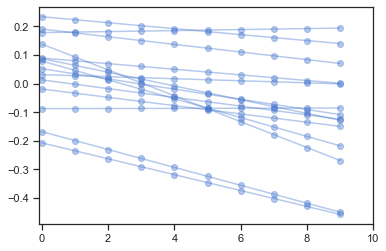

In [48]:
xvals = np.arange(10)
b = varying_intercept_slope_fit['a'].mean(axis=0)
m = varying_intercept_slope_fit['b'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 10);

Combining the model adjusting for the intercepts and the slopes led to the plot shown above. It suggests that the data have different behaviours depending on the county.

## Group-Level Predictors

One of the strengths of multilevel modelling is that ability to handle predictors that are defined at multiple levels simultaneously. For instance, we previously (notebook 08-partial_pooling_varying_intercept.ipynb) defined the varying intercept model to capture county-level variation in prevailing radon concentration:
$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

Instead of using a simple random effect to describe variation in the expected radon value for each county (as we do here: the parameter $\alpha_{j[i]}$ is drawn from a random distribution), we can specify another regression model that has a county-level radon concentration as its covariate, dependent on the county-level uranium measurement $u_j$ - such as:
$$\alpha_j = \gamma_0 + \gamma_1 u_j + \zeta_j$$

Where

* $\alpha_j$: county-level prevailing radon concentration
* $u_j$: the prevailing uranium concentration at county level
* $\gamma_0$: intercept of a linear model relating uranium level to radon level in a county
* $\gamma_1$: slope of a linear model relating uranium level to radon level in a county
* $\zeta_j$: irreducible noise in this relationship, where

$$\zeta_j \sim N(0, \sigma_{\alpha}^2)$$

In this new model, we are incorporating a house-level predictor (floor at which measurement is taken), and a county-level predictor (county uranium level).


### Specifying the model

We define the model in stan, as usual specifying data, parameters, transformed parameters and model blocks. The model is built up as follows.

Our observed log(radon) measurements ($y$) approximate an intermediate transformed parameter $\hat{y}$, which is normally distributed with variance $\sigma_y^2$ (we leave the estimation of $\sigma_y^2$ to Stan's defaults - this is not encouraged by Stan's authors, as the defaults may change between versions!).
$$y \sim N(\hat{y}, \sigma_y^2)$$

The transformed variable $\hat{y}$ is a linear function of $x_i$, the floor at which radon is measured. The parameters are $m_i$, the prevailing log(radon) measurement within the county $i$ ($i=1,\ldots,N$) in which each household is found, and the effect due to which floor is used for measurement, $\beta_2$.
$$\hat{y_i} = m_i + \beta_2 x_i$$

The transformed variable $m_i$ is a linear function of $u_i$, the uranium level in the county. The parameters are the intercept $\alpha_{j[i]}$, drawn from a Normal distribution with mean $\mu_{\alpha}$ and variance $\sigma_{\alpha}^2$, and the effect due to uranium level, $\beta_1$ (we again leave estimation of $\sigma_{\alpha}^2$ to Stan's defaults). The mean $\mu_{\alpha}$ is Normally distributed with mean 0 and unit variance.
$$m_i = \alpha_{j[i]} + \beta_1 u_i$$$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$$$\mu_{\alpha} \sim N(0, 1)$$

The values of $\beta_1$ and $\beta_2$ are Normally distributed with mean $0$ and variance $1$.
$$\beta_1 \sim N(0, 1)$$$$\beta_2 \sim N(0, 1)$$

In data:

* J is the number of counties (int)
* N is the number of samples (int)
* county is a list of N values from 1-85, specifying the county index each measurement
* u is a vector of uranium levels, in each county
* x is a vector of indices for which floor the radon measurements were taken at each household
* y is a vector of log(radon) measurements, one per household/sample.

We define parameters:

* a (vector, one value per county), representing $\alpha_j[i]$, the county-level intercept for the relationship of county radon level to county uranium level.
* mu_a, a real corresponding to $\mu_{\alpha}$, the mean radon level underlying the distribution from which the county levels are drawn.
* sigma_a is $\sigma_{\alpha}$, the standard deviation of the radon level distribution underlying the county levels: variability of county means about the average.
* b (vector, two values), representing: $\beta_1$, the slope of the relationship between county-level uranium and radon level; and $\beta_2$, the slope of the relationship between floor measurement and radon level.
* sigma_y is $\sigma_y$, the standard deviation of the measurement/sampling error: residual error of the observations.

In [49]:
hierarchical_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> county[N];
  vector[N] u;
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[J] a;
  vector[2] b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  vector[N] m;

  for (i in 1:N) {
    m[i] <- a[county[i]] + u[i] * b[1];
    y_hat[i] <- m[i] + x[i] * b[2];
  }
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal(mu_a, sigma_a);
  b ~ normal(0, 1);
  y ~ normal(y_hat, sigma_y);
}
"""

Fitting the model is quite similar to the other cases

In [65]:
n_county = srrs_az.groupby('county')['idnum'].count()  # number of samples from each county

hierarchical_intercept_data = {'N': len(log_radon),
                               'J': len(n_county),
                               'county': county+1, # Stan counts starting at 1
                               'u': u,
                               'x': floor_measure,
                               'y': log_radon}

hierarchical_intercept_fit = pystan.stan(model_code=hierarchical_intercept,
                                         data=hierarchical_intercept_data, 
                                         iter=1000, chains=2)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_09c24493b150e61b5f7babd2ed515f09 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


We can then extract mean estimates for each parameter (and standard deviation for estimate of county-level radon):

In [66]:
g0 = hierarchical_intercept_fit['mu_a'].mean()
g1 = hierarchical_intercept_fit['b'][:, 0].mean()
m_means = hierarchical_intercept_fit['m'].mean(axis=0)
m_se = hierarchical_intercept_fit['m'].std(axis=0)
m_county = hierarchical_intercept_fit['a'].mean(axis=0)

### Interpreting the model output

We can visualise the county-level estimate of radon level as a function of uranium level in the county (i.e. $m_i = \alpha_{j[i]} + \beta_1 u_i$) with a scatterplot:


0.4621415539683519

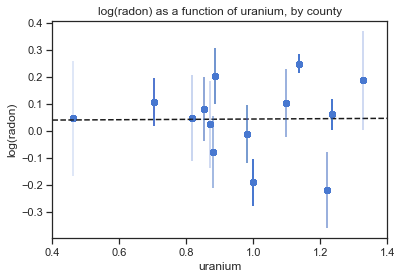

In [69]:
plt.scatter(u, m_means)
xvals = np.linspace(0.4, 1.4)
plt.plot(xvals, g0 + g1 * xvals, 'k--')  # fitted relationship
for ui, m, se in zip(u, m_means, m_se):  # std errors of fitted value
    plt.plot([ui, ui], [m - se, m + se], 'b-',
             linewidth=0.2, alpha=0.2)

# presentation
plt.xlim(0.4, 1.4)
plt.title("log(radon) as a function of uranium, by county")
plt.xlabel("uranium")
plt.ylabel("log(radon)");

From the plot shown above, the relation between the uranium and radon is almost flat. It's worth to mention that this case is not expected according to the original case analysed with the Minnesota dataset. The behaviour should look like this:

![](https://gitlab.com/msee2/pattern-recognition/-/raw/develop/Homework/Research3/img/goal_radon.png)

Nevertheless, the essential idea of global descriptors is conceptualised through the model.

### Prediction

Gelman (2006) used cross-validation tests to check the prediction error of the unpooled, pooled, and partially-pooled models

**root mean squared cross-validation prediction errors for the Minnesota case of this dataset**:

* unpooled = 0.86
* pooled = 0.84
* multilevel = 0.79

There are two types of prediction that can be made in a multilevel model:

1. a new individual within an existing group
2. a new individual within a new group

**For the first case: making a prediction within an existing group**

To get more interesting data, let's set the prediction on the 6th floor of Maricopa

In [73]:
county_lookup['MARICOPA']

6

That is, 

$$y_i = \alpha_{6[i]} + \beta_{6[i]} x_{i} + \epsilon_i$$

This is simply a matter of adding a single additional line in PyStan:

In [74]:
b = varying_intercept_slope_fit['a'][6].mean() # these 6 stands for the county
m = varying_intercept_slope_fit['b'][6].mean()

In [75]:
y = b + m * 6 # This 6 stands for the number of floor
print("6th floor in Maricopa:", np.exp(y))

6th floor in Maricopa: 1.0535152191371724


**For the second case: making a prediction for an unknown county**

For this case, we need to generalise the model having the group-level predictor. In this case, we will need to have a common descriptor for all the counties. In this case, the level of uranium is the most proper value for this task.

In [76]:
b = hierarchical_intercept_fit['mu_a'].mean()
m = hierarchical_intercept_fit['b'][:, 0].mean()

In [77]:
y = b + m * 6
print("6th floor in an unknown county:", np.exp(y))

6th floor in an unknown county: 1.0782931504509101


Still, the result is quite similar between an specific place to an unknown place, suggesting that the HBM is generalising the model.

## Benefits of Multilevel Models

Accounting for natural hierarchical structure of observational data

Estimation of coefficients for (under-represented) groups

Incorporating individual- and group-level information when estimating group-level coefficients

Allowing for variation among individual-level coefficients across groups



## References

Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.

Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot do. Technometrics, 48(3), 432–435.